In [1]:
from __future__ import print_function, division
import scipy
from keras.models import load_model
import matplotlib.pyplot as plt
import sys
import numpy as np
import os
from tqdm import tqdm
import keras
import pandas as pd
from keras.datasets import mnist
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils import np_utils
import datetime
import matplotlib.pyplot as plt
import sys
import numpy as np
import os
import cv2
import helpers

#Root directory of the project
ROOT_DIR = os.path.abspath(".")
# Training file directory
DATASET = os.path.join(ROOT_DIR, 'dataset')

PATH = "{}/{}".format(DATASET, "isic2016numpy")
# load data
x_train = np.load("{}/x_train.npy".format(PATH))
y_train = np.load("{}/y_train.npy".format(PATH))
x_train.shape, y_train.shape

MODEL_PATH = os.path.join(ROOT_DIR, "models")
print(os.listdir(MODEL_PATH))

Using TensorFlow backend.


['generator_100.h5', 'generator_200.h5', 'generator_250.h5']


In [2]:
model = load_model(os.path.join(MODEL_PATH, 'generator_250.h5'), custom_objects={'InstanceNormalization':InstanceNormalization})
#model.summary()

C:\Users\Hasib\Anaconda3\envs\skin\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [3]:
def predict(model, img):
    
    if img.shape[0] != 256:
        print("Resizing image..")
        img = cv2.resize(img, (256, 256))
    
    # Normalize image as the trained distribution
    
    img = img/127.5 - 1.
    
    # Normalize imgae [0, 1]
    #img = img.astype('float32')
    #img /= 255.
    
    img = np.expand_dims(img, axis=0)
    img = model.predict(img)
    img = np.squeeze(img, axis=0)
    
    
    # Rescale to [0,1]
    #img = 0.5 * img + 0.5
    img = (img - np.min(img))/np.ptp(img)
    
    return img


def oversample(x, y, model):
    '''
    Some cool stuff
    INPUT
        x: 
        y:
        model:
        
    OUTPUT
        New folder in the current directory.
    '''
    
    print("Before oversampling :", x.shape, y.shape)
    
    
    # majority class
    majority_samples = []
    for img, label in zip(x, y):
        if label[1] == 0:
            majority_samples.append(img)
        else:
            pass
    
    # numpy array of majority classes
    majority_samples = np.array(majority_samples)
    
    # minority generated samples
    synthetic_samples = []
    
    # iterate over majority samples and generate minority class
    for img in tqdm(majority_samples):
        
        # translate to malignant
        pred = predict(model, img)
        synthetic_samples.append(pred)
    
    # make labels for generated minority classes
    y_syn = np.array([1 for _ in range(len(synthetic_samples))])
    y_syn = np_utils.to_categorical(y_syn, 2)
    
    # Scale training set to [0, 1]
    x = x.astype('float32')
    x /= 255
    
    # merge and shuffle training and generated samples
    x_balanced = np.concatenate( (x, synthetic_samples), axis = 0)
    y_balanced = np.concatenate( (y, y_syn), axis = 0)
    x_balanced, y_balanced = helpers.shuffle_dataset(x_balanced, y_balanced)
    
    assert len(majority_samples) == len(synthetic_samples), "This should be same! If not, check model code"
    assert len(x_balanced) == len(synthetic_samples) + len(x_train), "Check oversampler code"
    print("After oversampling: ", x_balanced.shape, y_balanced.shape)
    
    return majority_samples, synthetic_samples, x_balanced, y_balanced


In [4]:
raw, gen, x_new, y_new = oversample(x_train, y_train, model)

Before oversampling : (900, 256, 256, 3) (900, 2)


  0%|                                                  | 0/727 [00:00<?, ?it/s]

100%|████████████████████████████████████████| 727/727 [00:55<00:00, 13.15it/s]


Shuffling data
After oversampling:  (1627, 256, 256, 3) (1627, 2)


In [5]:
np.array(gen).shape

(727, 256, 256, 3)

In [6]:
max(np.array(gen).flatten()), min(np.array(gen).flatten())

(1.0, 0.0)

In [7]:
max(x_new.flatten()), min(x_new.flatten())

(1.0, 0.0)

In [8]:
# use standard preprocessing
#x_train_pre = x_train.astype('float32')
#x_train_pre /= 255

# get one image
#ct = 200
#img = x_train[ct]
#helpers.plot_hist(img)
#plt.imshow(img)

In [9]:
# transform image
#img_g = predict(model, img)
#helpers.plot_hist(img_g)
#plt.imshow(img_g)

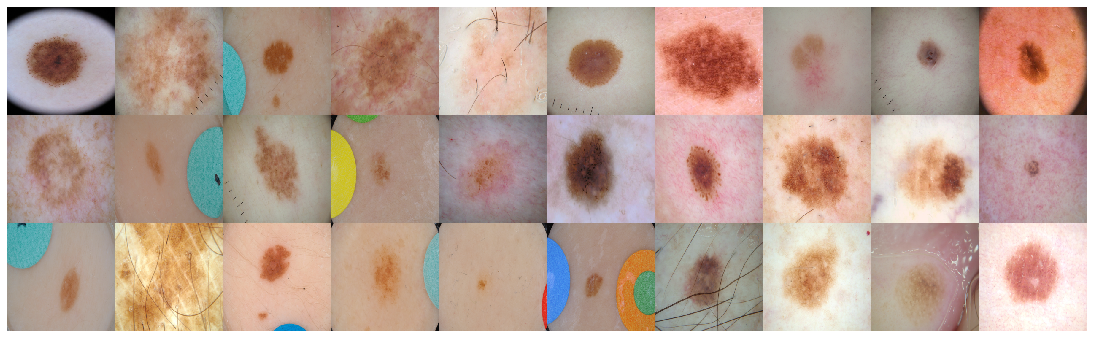

In [68]:
from numpy.random import rand
import matplotlib.pyplot as plt

index = np.random.choice(np.array(gen).shape[0], 30, replace=False)
raw = np.array(raw)
x = raw[index]

a, b = 3, 10
x = np.reshape(x, (a, b, 256, 256, 3))


test_data = x
r, c = test_data.shape[0], test_data.shape[1]
#test_data = np.array([[cancer[0], cancer[0]],[cancer[0], cancer[0]],[cancer[0], cancer[0]]])
#test_data = np.array([[rand(10,10), rand(10,10)],[rand(5,10), rand(5,10)],[rand(2,10), rand(2,10)]])
cmaps = [['viridis', 'binary'], ['plasma', 'coolwarm'], ['Greens', 'copper']]

heights = [a[0].shape[0] for a in test_data]
widths = [a.shape[1] for a in test_data[0]]

fig_width = 15.  # inches
fig_height = fig_width * sum(heights) / sum(widths)

f, axarr = plt.subplots(r,c, figsize=(fig_width, fig_height),
        gridspec_kw={'height_ratios':heights})

for i in range(r):
    for j in range(c):
        axarr[i, j].imshow(test_data[i][j])
        axarr[i, j].axis('off')
        
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
plt.savefig('{}/{}.pdf'.format("{}/outputs/".format(ROOT_DIR), "beforegan"), dpi=300)
plt.show()

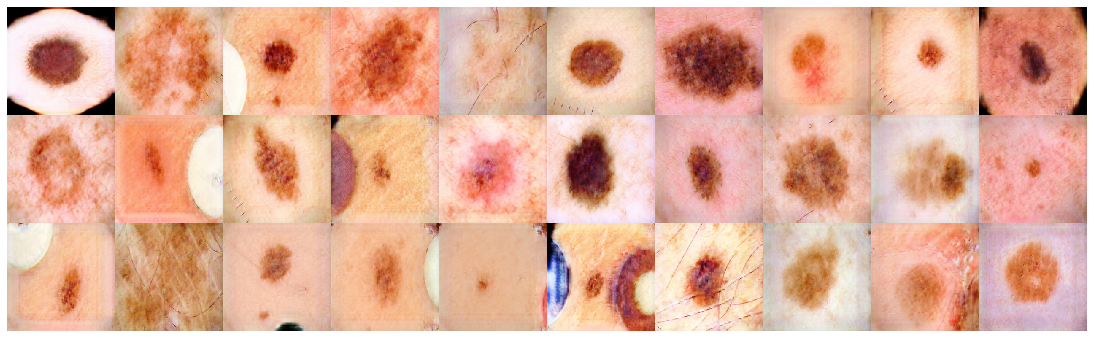

In [69]:
from numpy.random import rand
import matplotlib.pyplot as plt

#index = np.random.choice(np.array(gen).shape[0], 20, replace=False)
gen = np.array(gen)
x = gen[index]

a, b = 3, 10
x = np.reshape(x, (a, b, 256, 256, 3))


test_data = x
r, c = test_data.shape[0], test_data.shape[1]
#test_data = np.array([[cancer[0], cancer[0]],[cancer[0], cancer[0]],[cancer[0], cancer[0]]])
#test_data = np.array([[rand(10,10), rand(10,10)],[rand(5,10), rand(5,10)],[rand(2,10), rand(2,10)]])
cmaps = [['viridis', 'binary'], ['plasma', 'coolwarm'], ['Greens', 'copper']]

heights = [a[0].shape[0] for a in test_data]
widths = [a.shape[1] for a in test_data[0]]

fig_width = 15.  # inches
fig_height = fig_width * sum(heights) / sum(widths)

f, axarr = plt.subplots(r,c, figsize=(fig_width, fig_height),
        gridspec_kw={'height_ratios':heights})

for i in range(r):
    for j in range(c):
        axarr[i, j].imshow(test_data[i][j])
        axarr[i, j].axis('off')
        
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
plt.savefig('{}/{}.pdf'.format("{}/outputs/".format(ROOT_DIR), "aftergan"), dpi=300)
plt.show()

In [11]:
#helpers.show_images(raw[-20:], cols = 3, titles = None, save_fig = "default")

In [12]:
#helpers.show_images(gen[-20:], cols = 3, titles = None, save_fig = "default")

In [13]:
a = np.array([np.argmax(y) for y in y_new])
len(a)

1627

In [14]:
np.count_nonzero(a == 0), np.count_nonzero(a == 1)

(727, 900)

In [15]:
# Create directory
helpers.create_directory("dataset/isic2016gan/")

# Save
np.save("dataset/isic2016gan/{}.npy".format("x_gan_250"), x_new)
np.save("dataset/isic2016gan/{}.npy".format("y_gan_250"), y_new)